In [114]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS, OLSResults, RegressionResults
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('../data/preprocessed_data.csv', index_col=0)

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
df.head()

,severity,num_vehicles,num_casualties,doy,Speed_limit,urb_or_rur,police_presence,hazard_Any animal (except a ridden horse),hazard_Dislodged vehicle load in carriageway,hazard_Involvement with previous accident,...,Zebra crossing,non-junction pedestrian crossing,rtype_Dual carriageway,rtype_One way street,rtype_Roundabout,rtype_Single carriageway,rtype_Slip road,rtype_Unknown,weekend,night
0,3,2,1,5,0.428571,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,3,2,1,4,0.428571,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3,2,1,3,0.428571,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,3,1,1,4,0.428571,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,3,1,1,3,0.428571,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [5]:
df.columns

Index(['severity', 'num_vehicles', 'num_casualties', 'doy', 'Speed_limit',
       'urb_or_rur', 'police_presence',
       'hazard_Any animal (except a ridden horse)',
       'hazard_Dislodged vehicle load in carriageway',
       'hazard_Involvement with previous accident',
       'hazard_Other object in carriageway',
       'hazard_Pedestrian in carriageway (not injured)',
       'road_Flood (Over 3cm of water)', 'road_Frost/Ice', 'road_Snow',
       'road_Wet/Damp', 'weather_Fine with high winds',
       'weather_Fine without high winds', 'weather_Fog or mist',
       'weather_Other', 'weather_Raining with high winds',
       'weather_Raining without high winds', 'weather_Snowing with high winds',
       'weather_Snowing without high winds', 'weather_Unknown',
       'Darkeness: No street lighting', 'Darkness: Street lighting unknown',
       'Darkness: Street lights present and lit',
       'Darkness: Street lights present but unlit', 'Central refuge',
       'Footbridge or subway', 

In [6]:
df.severity.value_counts()

3    1275940
2     204118
1      19415
Name: severity, dtype: int64

### Creating new df with only the variables that we want to run through the PCA. We will not use num_vehicles and num_casualties since it's an information that it's only available AFTER a car accident. We will also drop doy(day of week) since we have the weekend categorical column.

### Also, given that our categories aren't balanced at all we will proceed with a downsampling of the rows with category 2 and 3 so that we can have a balanced dataset to test our models on.

In [10]:
df_downsample = df[df.severity == 1]
df_downsample = pd.concat([df_downsample, df[df.severity == 2].sample(len(df_downsample)), 
          df[df.severity == 3].sample(len(df_downsample))])

In [18]:
target = df_downsample.severity

In [105]:
df_X = df_downsample.drop(['num_vehicles', 'num_casualties', 'doy'], axis=1)

### Selecting features through OLS

In [21]:
ols_features = OLS(target, df_X)

In [22]:
results = ols_features.fit()

In [29]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               severity   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     316.9
Date:                Wed, 21 Aug 2019   Prob (F-statistic):               0.00
Time:                        15:51:09   Log-Likelihood:                -65625.
No. Observations:               58245   AIC:                         1.313e+05
Df Residuals:                   58208   BIC:                         1.317e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Speed_limit                                       -0.6970      0.024    -29.400      0.000      -0.744      -0.651
urb_or_rur                                        -0.1409      0.010    -14.681      0.000      -0.160      -0.122
police_presence                                   -0.5351      0.011    -50.474      0.000      -0.556      -0.514
hazard_Any animal (except a ridden horse)          0.3955      0.044      8.891      0.000       0.308       0.483
hazard_Dislodged vehicle load in carriageway       0.1778      0.097      1.827      0.068      -0.013       0.369
hazard_Involvement with previous accident         -0.0462      0.057     -0.809      0.418      -0.158       0.066
hazard_Other object in carriageway                 0.0133      0.032      0.413      0.680      -0.050       0.076
hazard_Pedestrian in carriageway (not injured)    -0.0095      0.066     -0.144      0.885      -0.139       0.120
road_Flood (Over 3cm of water)                     0.0651      0.077      0.844      0.399      -0.086       0.216
road_Frost/Ice                                     0.1940      0.024      8.032      0.000       0.147       0.241
road_Snow                                          0.2637      0.055      4.832      0.000       0.157       0.371
road_Wet/Damp                                     -0.0082      0.009     -0.932      0.351      -0.025       0.009
weather_Fine with high winds                       1.1548      0.028     41.948      0.000       1.101       1.209
weather_Fine without high winds                    1.2252      0.012     99.670      0.000       1.201       1.249
weather_Fog or mist                                1.2581      0.037     33.702      0.000       1.185       1.331
weather_Other                                      1.3733      0.024     57.184      0.000       1.326       1.420
weather_Raining with high winds                    1.3253      0.028     46.980      0.000       1.270       1.381
weather_Raining without high winds                 1.3804      0.016     88.815      0.000       1.350       1.411
weather_Snowing with high winds                    1.4459      0.091     15.842      0.000       1.267       1.625
weather_Snowing without high winds                 1.3634      0.048     28.488      0.000       1.270       1.457
weather_Unknown                                    1.1818      0.026     44.750      0.000       1.130       1.234
Darkeness: No street lighting                     -0.1717      0.012    -14.351      0.000      -0.195      -0.148
Darkness: Street lighting unknown                 -0.0431      0.032     -1.366      0.172      -0.105       0.019
Darkness: Street lights present and lit           -0.1110      0.009    -12.308      0.000   

### We will start by eliminating all the attributes with a p-value higher than 0.05 because we cannot reject the null hypothesis that the related coefficient is 0, meaning that they do not contribute to our target.

In [30]:
features_to_remove = results.pvalues[results.pvalues > 0.05]

In [33]:
df_ols = df_X.drop(features_to_remove.index, axis=1)

In [50]:
len(df_ols.columns)

29

### We will now try to use a Linear Regression model to predict the severity of an accident

Splitting the data in a stratified fashion

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df_ols, target,
                                                    stratify=target, 
                                                    test_size=0.25)

In [35]:
lin_model = LinearRegression()

In [36]:
lin_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [43]:
y_pred = np.round(lin_model.predict(X_train))

In [44]:
accuracy_score(y_train, y_pred)

0.3908843257102305

The accuracy is really low therefore we will try to eliminate some features and check the model again. We were using 29 features in the previous model and we will try going down to 20. We will therefore pick the 20 features with the lowest p-values.

In [53]:
features_to_keep = results.pvalues.sort_values().head(20)

In [55]:
df_ols = df_ols[features_to_keep.index]

Splitting the data again.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(df_ols, target,
                                                    stratify=target, 
                                                    test_size=0.25)

In [58]:
lin_model = LinearRegression()

In [59]:
lin_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [60]:
y_pred = np.round(lin_model.predict(X_train))

In [61]:
accuracy_score(y_train, y_pred)

0.3898770688826317

We will now try going down to 15 features.

In [70]:
features_to_keep = results.pvalues.sort_values().head(15)

In [71]:
df_ols = df_ols[features_to_keep.index]

In [72]:
X_train, X_test, y_train, y_test = train_test_split(df_ols, target,
                                                    stratify=target, 
                                                    test_size=0.25)

In [73]:
lin_model = LinearRegression()

In [74]:
lin_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [75]:
y_pred = np.round(lin_model.predict(X_train))

In [76]:
accuracy_score(y_train, y_pred)

0.36895359750932855

In [77]:
df_ols.columns

Index(['rtype_Unknown', 'police_presence', 'rtype_Slip road',
       'rtype_Single carriageway', 'rtype_Roundabout', 'rtype_One way street',
       'rtype_Dual carriageway', 'weather_Unknown',
       'weather_Raining without high winds', 'weather_Raining with high winds',
       'weather_Fine with high winds', 'weather_Fine without high winds',
       'weather_Other', 'weather_Fog or mist', 'Speed_limit'],
      dtype='object')

We will now try with another feature selection method, where we try to understand which features are more related to our target.

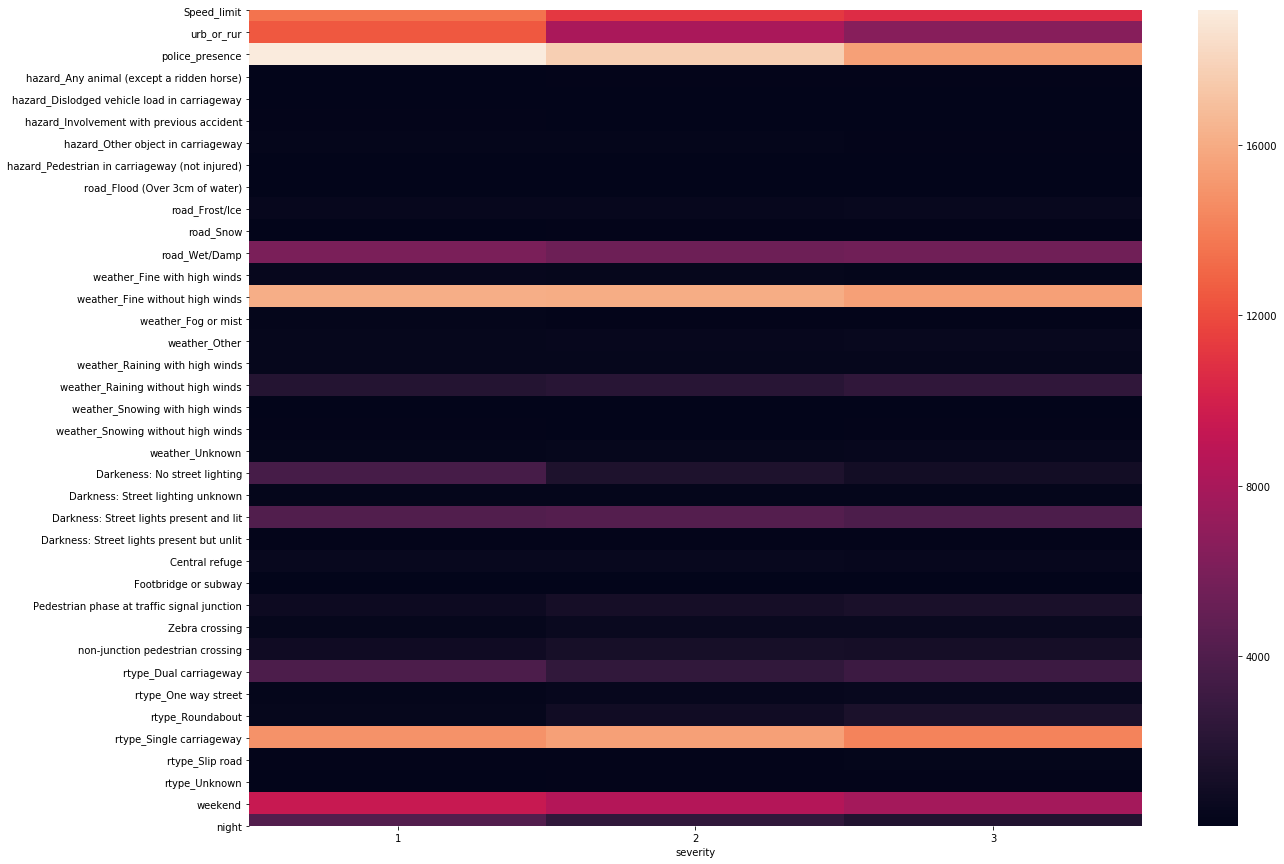

In [106]:
plt.figure(figsize=(20,15))
sns.heatmap(df_X.groupby('severity').sum().transpose())

In [107]:
features = ['Speed_limit', 'urb_or_rur', 'police_presence', 'road_Wet/Damp', 
            'weather_Raining without high winds', 'Darkeness: No street lighting',
            'Darkness: Street lights present and lit', 'Pedestrian phase at traffic signal junction',
            'rtype_Dual carriageway', 'rtype_Single carriageway', 'weekend', 'night']

In [108]:
df_ols = df_X[features]

In [109]:
X_train, X_test, y_train, y_test = train_test_split(df_ols, target,
                                                    stratify=target, 
                                                    test_size=0.25)

In [110]:
lin_model = LinearRegression()

In [111]:
lin_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [112]:
y_pred = np.round(lin_model.predict(X_train))

In [113]:
accuracy_score(y_train, y_pred)

0.38788544742806125

### Given the low accuracy results we will now try to predict using the K-NN model

In [115]:
knn_model = KNeighborsClassifier()

In [116]:
param_grid = {'n_neighbors': [2, 5, 10, 25, 50],
              'leaf_size': [15, 30, 70, 150]}

In [117]:
hyperparameters = RandomizedSearchCV(knn_model, param_grid, n_iter=100, verbose=2, n_jobs=-1)

In [118]:
hyperparameters.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.6min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'leaf_size': [15, 30, 70, 150],
                                        'n_neighbors': [2, 5, 10, 25, 50]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [119]:
hyperparameters.best_params_

{'n_neighbors': 50, 'leaf_size': 30}

We will now fit the knn model with the best parameters the Randomized search gave us

In [120]:
knn_model = KNeighborsClassifier(n_neighbors=50, leaf_size=30)

In [121]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

In [124]:
knn_model.score(X_train, y_train)

0.48064464436966325

The score has increased compared to our many trials with a Linear Regression and we will therefore try to improve our feature selection and hyperparameters with the KNN model. We will first try again with a previously selected set of features.

In [127]:
df_ols = df_X.drop(features_to_remove.index, axis=1)

In [142]:
df_ols = df_ols.drop('severity', axis=1)

In [143]:
X_train, X_test, y_train, y_test = train_test_split(df_ols, target,
                                                    stratify=target, 
                                                    test_size=0.25)

In [144]:
knn_model = KNeighborsClassifier()

In [145]:
param_grid = {'n_neighbors':[25, 50, 100, 200, 500],
              'leaf_size': [15, 30, 70, 150]}

In [146]:
hyperparameters = RandomizedSearchCV(knn_model, param_grid, n_iter=100, verbose=2, n_jobs=-1)

In [147]:
hyperparameters.fit(X_train, y_train)

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.6min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'leaf_size': [15, 30, 70, 150],
                                        'n_neighbors': [25, 50, 100, 200, 500]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [148]:
hyperparameters.best_params_

{'n_neighbors': 200, 'leaf_size': 15}

In [149]:
knn_model = KNeighborsClassifier(n_neighbors=200, leaf_size=15)

In [150]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=15, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=200, p=2,
                     weights='uniform')

In [151]:
knn_model.score(X_train, y_train)

0.48082778197468123

In [152]:
y_pred = knn_model.predict(X_test)

In [153]:
accuracy_score(y_test, y_pred)

0.48331273176761436